# Hyperoptimization

In this tutorial, we show how to optimize the parameters of an RNN regression model with the deep4cast package. We will use temporal (causal) cross-validation (backtesting) to evaluate the model. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [4]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.validators import TemporalCrossValidator
from deep4cast.optimizers import HyperOptimizer
from pandas import read_table

%matplotlib inline

## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [5]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

# Prepare the data set
ts = df.astype('float32').values
ts = np.expand_dims(ts, axis=-1)

Before we do anything, we should probably quickly visualize the data.

Text(0,0.5,'Quantity')

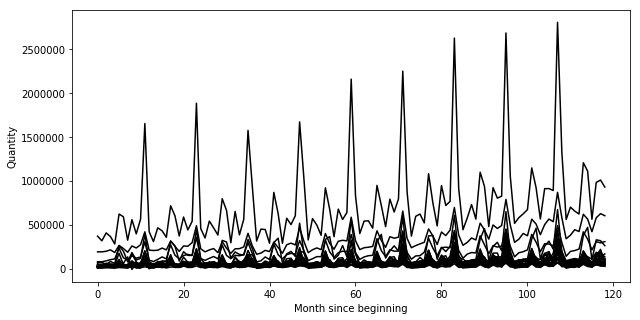

In [6]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:,:,0], 'k')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')

## Hyperoptimization

Now that we have cleaned and prepared out dataset we can proceed to optimize one of our built-in regression models. Here, we choose the RNN. The optmizer is initalized with
* a topology object,
* a forecaster,
* a data_set to train and validate on
* a parameter domain, 
* and some other parameters.

In [10]:
# Forecaster setup
topology = [
    {
        'meta': {
            'layer_type': 'Conv1D',
            'layer_id': 'conv1',
            'parent_ids': ['input']
        },
        'params': {
            'filters': 128, 
            'kernel_size': 5
        }
    },    
    {
        'meta': {
            'layer_type': 'GRU',
            'layer_id': 'gru1',
            'parent_ids': ['conv1']
        },
        'params': {
            'units': 128, 
            'return_sequences': True
        }
    },
    {
        'meta': {
            'layer_type': 'TemporalAttention',
            'layer_id': 'att1',
            'parent_ids': ['gru1']
        },
        'params': {}
    },
    {
        'meta': {
            'layer_type': 'AutoRegression',
            'layer_id': 'ar1',
            'parent_ids': ['input']
        },
        'params': {}
    },
    {
        'meta': {
            'layer_type': 'Concatenate',
            'layer_id': 'con1',
            'parent_ids': ['ar1', 'att1']
        },
        'params': {}
    }
]
params = {
    'topology': topology, 
    'optimizer': 'sgd',
    'lag': 20, 
    'horizon': 1, 
    'batch_size': 8, 
    'epochs': 50, 
    'lr': 0.01, 
    'uncertainty': False
}
forecaster = Forecaster(**params)
forecaster.seed = 3

# Instantiate the optimizer
domain = {
        'forecaster': {
            'lag': (10, 50)
        },
        'topology': {
            'conv1_filters': (16, 256), 
            'conv1_kernel_size': (2, 7),
            'gru1_units': (16, 256)
        },
        'optimizer': {
            'lr': (-7, -1)
        },
}
optimizer = HyperOptimizer(forecaster, ts, domain, n_iter=100, train_frac=0.9, n_folds=1, loss='mape')

Let's perform optimization

In [ ]:
best_values, trials = optimizer.fit()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Let's have a look at the cross-validation scores

In [7]:
# Remove nan's from losses
losses = np.array(trials.losses())
losses = losses[np.isfinite(losses)]

# Show bet values
best_values, min(losses)

({'c1_filters': 225.0,
  'c2_filters': 62.0,
  'c3_filters': 70.0,
  'd1_units': 251.0,
  'd2_units': 366.0,
  'dropout_rate': 0.14595281068591331,
  'lag': 46.0,
  'lr': 0.05470275622957353},
 14.51)